# Introduction

The data we are using in this are 220k 96x96 tif images in which we need to determine if there is or is not cancer in the center 32x32 region. To tackle this problem I will create a CNN to classify the images.

The data can be found [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview)

Below are all of the libraries I used

In [2]:
import tensorflow
from  tensorflow import keras
from glob import glob
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

# Load the data in

How I load the data is based on [this](https://medium.com/swlh/how-to-bring-kaggle-dataset-into-azure-ml-workspace-in-azure-portal-ebf8aec795be#:~:text=Steps%20for%20connecting%20Kaggle%20data%20in%20Azure&text=Click%20on%20Create%20a%20Resource,one%20does%20not%20exist%20already) medium post by Dr. Varshita Sher.

In [ ]:
!pwd

In [ ]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
"chmod 600 /kaggle.json"

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

In [ ]:
%%capture
!unzip "./histopathologic-cancer-detection.zip"

In [ ]:
path = "./" 

df = pd.DataFrame({'path': glob(os.path.join('./train/','*.tif'))})

df['id'] = df.path.map(lambda x: x.split('/')[2].split(".")[0])
labels = pd.read_csv("./train_labels.csv")
df = df.merge(labels, on = "id")

In [5]:
df.head() # print the first three entrys

,path,id,label
0,./train/00001b2b5609af42ab0ab276dd4cd41c3e7745...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,./train/000020de2aa6193f4c160e398a8edea95b1da5...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,./train/00004aab08381d25d315384d646f5ce413ea24...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,./train/0000d563d5cfafc4e68acb7c9829258a298d9b...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,./train/0000da768d06b879e5754c43e2298ce48726f7...,0000da768d06b879e5754c43e2298ce48726f722,1


In [6]:
def data_import(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = df['label'].values[:N]
    for i, row in tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [ ]:
N = df["path"].size
X,y = data_import(N=N,df=df)

# EDA

Below we can see a sample of images from the data set to see what we are working with.

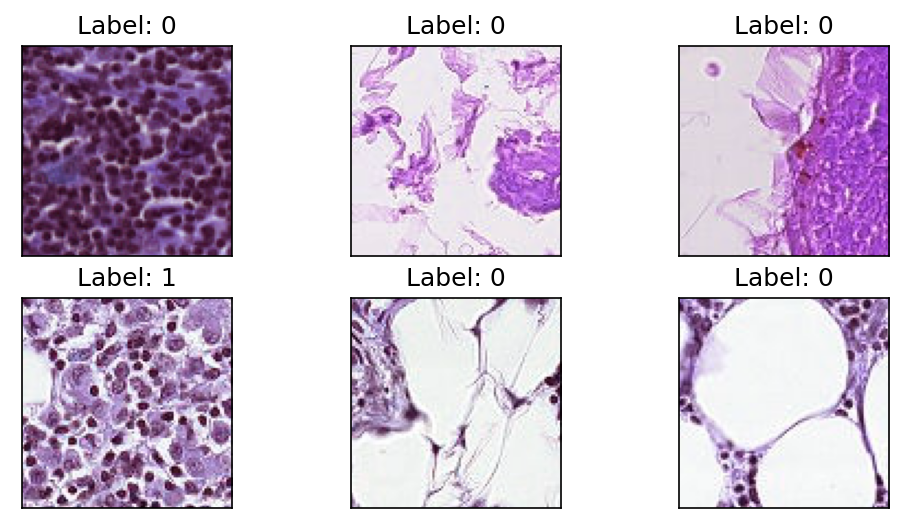

In [11]:
fig = plt.figure(figsize=(8, 4))
np.random.seed(42)
for pl,id in enumerate(np.random.randint(0,N,6)):
    ax = fig.add_subplot(2, 6//2, pl+1, xticks=[], yticks=[]) 
    plt.imshow(X[id])
    ax.set_title('Label: ' + str(y[id]))

Below is the distribution of images with positive vs negative labels.

Text(0, 0.5, '# of samples')

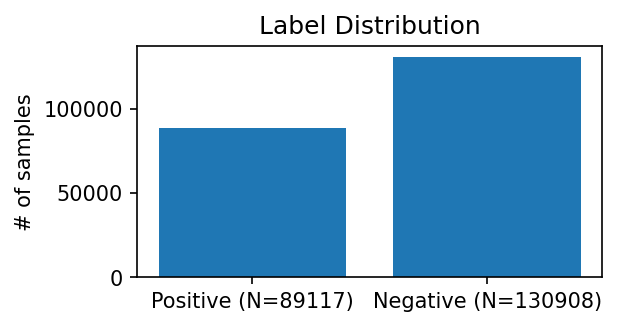

In [13]:
fig = plt.figure(figsize=(4, 2))
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.title("Label Distribution")
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples")

Below I split the data into train (.7) and test (.3) sets.

In [14]:
train_set = 0.7 
split = int(np.round(train_set * y.shape[0])) 
np.random.seed(42) 

# The Model
Now we are ready to create the model.

Below is the function to create my model with kernel size, pool size, first filters, second filters, and third filters a parameters.

For my model I chose to create a model with 3 convolution layers and 2 dense layers. The reason for this is that it follows the baseline archicecture we saw in lecture and I believe it to be a good starting point for my model.


In [15]:
def model_create(kernel_size = (3,3), pool_size= (2,2), first_filters = 32, second_filters = 64, third_filters = 128):

    conv_drop = 0.3
    dense_drop = 0.5

    model = Sequential()

    # First Conv
    model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size)) 
    model.add(Dropout(conv_drop))

    # Second Conv
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(conv_drop))

    # Third Conv
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(conv_drop))

    # Dense layer 1
    model.add(Flatten())
    model.add(Dense(256, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dense_drop))

    # Dense layer 2
    model.add(Dense(128, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dense_drop))


    model.add(Dense(1, activation = "sigmoid"))

    return(model)

Creating my model

In [16]:
my_model = model_create()

2023-07-28 19:57:28.830627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Setting the batch size to 100 and compiling the model

In [17]:
batch = 100

my_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])

Training the model for 5 epochs.

In [ ]:
epochs = 5 
for epoch in range(epochs):
    iterations = np.floor(split / batch).astype(int) 
    loss,acc = 0,0 
    with trange(iterations) as t: 
        for i in t:
            start = i * batch 
            x_batch = X[start:start+batch] 
            y_batch = y[start:start+batch] 
            metrics = my_model.train_on_batch(x_batch, y_batch) 
            loss = loss + metrics[0] 
            acc = acc + metrics[1] 

# Results
Below I perform a validation epoch 

In [ ]:
iterations = np.floor((y.shape[0]-split) / batch).astype(int) 
loss,acc = 0,0 
with trange(iterations) as t: 
    for i in t:
        start = i * batch 
        x_batch = X[start:start+batch] 
        y_batch = y[start:start+batch] 
        metrics = my_model.test_on_batch(x_batch, y_batch) 
        loss = loss + metrics[0] 
        acc = acc + metrics[1] 
        

Predicting based on the trained model and creating the submission file.

In [ ]:
# Creating submission path
base_test_dir = path + 'test/' 
test_files = glob(os.path.join(base_test_dir,'*.tif')) 
submission = pd.DataFrame() 
files = 1000 
max_id = len(test_files) 

for id in range(0, max_id, files): 
    print("Indexes: %i - %i"%(id, id+files))
    test = pd.DataFrame({'path': test_files[id:id+files]}) 
    test['id'] = test.path.map(lambda x: x.split('/')[2].split(".")[0]) 
    test['image'] = test['path'].map(cv2.imread) 
    K_test = np.stack(test["image"].values) 
    pred = my_model.predict(K_test,verbose = 1) 
    test['label'] = pred 
    submission = pd.concat([submission, test[["id", "label"]]])
submission.head() 

Summary of the model

In [15]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 94, 94, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 94, 94, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 92, 92, 32)        0

As you can see below, my best model received a .8662 private score and a .8714 public score on kaggle. While this result is decent, I believe there is room for improvement to push the scores above .9 or even higher. 

I tried multiple different paramters for my build model function including different filter sizes and pool sizes but this is the best result I could acheive in a reasonable timeframe.

![Submission](kaggle_submission.png)

Somethings that could result in an improved perfomance would be using grid-search for hyperparamter tuning, trying different batch sizes, different number of epochs, or adjusting the structure of my CNN.

# Conclusion

Writing the submission to a csv file to upload to Kaggle

In [16]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

Ultimatly, I think this was a decent first attempt given the limiations of a weekly assignment. Some things that I did not expect (but probably should have) were the amount of time needed to load in the data, the length of training, and the difficulting exploring the data in meaninful ways.